<a href="https://colab.research.google.com/github/dj1095/cse6363-ml-tutorial/blob/master/Cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import Food101
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import numpy as np
import os
import splitfolders

In [21]:
img_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.RandAugment(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


dataset = Food101('./food-101', transform= img_transforms, download=True)

if 'food-101' in os.listdir() and 'train-val-data' not in os.listdir() :
    splitfolders.ratio("./food-101/food-101/images", output="train-val-data", seed=1337, ratio=(.8, .2), group_prefix=None)

In [ ]:
if "output" not in os.listdir():
  splitfolders.ratio("/content/food-101/images/", output="output", seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 101000 files [01:58, 851.25 files/s] 


In [ ]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [22]:
#Hyper Parameters
batch_size = 32
learning_rate = 0.001
epochs = 50

In [23]:
traindataset = datasets.ImageFolder('./train-val-data/train', transform=train_transforms)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size,shuffle=True)

testdataset = datasets.ImageFolder('./train-val-data/val', transform=test_transforms)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=True)

In [24]:
data_dict = traindataset.class_to_idx
classes = {key : value for value, key in data_dict.items()}
print(classes)

{0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'beef_carpaccio', 4: 'beef_tartare', 5: 'beet_salad', 6: 'beignets', 7: 'bibimbap', 8: 'bread_pudding', 9: 'breakfast_burrito', 10: 'bruschetta', 11: 'caesar_salad', 12: 'cannoli', 13: 'caprese_salad', 14: 'carrot_cake', 15: 'ceviche', 16: 'cheese_plate', 17: 'cheesecake', 18: 'chicken_curry', 19: 'chicken_quesadilla', 20: 'chicken_wings', 21: 'chocolate_cake', 22: 'chocolate_mousse', 23: 'churros', 24: 'clam_chowder', 25: 'club_sandwich', 26: 'crab_cakes', 27: 'creme_brulee', 28: 'croque_madame', 29: 'cup_cakes', 30: 'deviled_eggs', 31: 'donuts', 32: 'dumplings', 33: 'edamame', 34: 'eggs_benedict', 35: 'escargots', 36: 'falafel', 37: 'filet_mignon', 38: 'fish_and_chips', 39: 'foie_gras', 40: 'french_fries', 41: 'french_onion_soup', 42: 'french_toast', 43: 'fried_calamari', 44: 'fried_rice', 45: 'frozen_yogurt', 46: 'garlic_bread', 47: 'gnocchi', 48: 'greek_salad', 49: 'grilled_cheese_sandwich', 50: 'grilled_salmon', 51: 'guacamole

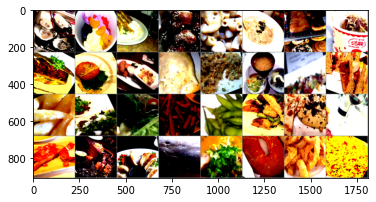

oysters frozen_yogurt carrot_cake donuts macaroni_and_cheese ravioli donuts takoyaki grilled_salmon crab_cakes macaroni_and_cheese breakfast_burrito fried_rice miso_soup beet_salad club_sandwich french_fries tacos caprese_salad french_fries edamame grilled_salmon hummus beef_tartare bruschetta pork_chop gyoza apple_pie ramen donuts onion_rings fried_rice


In [25]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j].item()]:5s}' for j in range(batch_size)))

In [26]:
class BasicCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
          nn.Conv2d(3, 6, 5),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(6, 16, 5),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
        
        self.estimator = nn.Sequential(
            nn.Linear(44944, 400), 
            nn.ReLU(),
            nn.Linear(400, 84),
            nn.ReLU(),
            nn.Linear(84, 101),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        return self.estimator(x)

basic_cnn_model = BasicCnn()

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(basic_cnn_model.parameters(), lr=learning_rate)

In [28]:
def get_accuracy(dataloader,cnn_model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = cnn_model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return round(correct/total,3)

Epoch [1/50], Step [2525/2525], Time taken:[2409.694 seconds], Loss: 5.5770
epoch-1 i - 0 , loss = 4.403316497802734
epoch-1 i - 1 , loss = 8.935100078582764
epoch-1 i - 2 , loss = 13.505703926086426
epoch-1 i - 3 , loss = 18.130287647247314
epoch-1 i - 4 , loss = 22.762907028198242
epoch-1 i - 5 , loss = 27.34198808670044
epoch-1 i - 6 , loss = 31.991257190704346
epoch-1 i - 7 , loss = 36.44807720184326
epoch-1 i - 8 , loss = 40.9439959526062
epoch-1 i - 9 , loss = 45.551456928253174
epoch-1 i - 10 , loss = 50.16575288772583
epoch-1 i - 11 , loss = 54.79433822631836
epoch-1 i - 12 , loss = 59.37271690368652
epoch-1 i - 13 , loss = 64.00487041473389
epoch-1 i - 14 , loss = 68.58005952835083
epoch-1 i - 15 , loss = 73.12874937057495
epoch-1 i - 16 , loss = 77.79607391357422
epoch-1 i - 17 , loss = 82.38001585006714
epoch-1 i - 18 , loss = 86.97344541549683
epoch-1 i - 19 , loss = 91.61274528503418
epoch-1 i - 20 , loss = 95.96422481536865
epoch-1 i - 21 , loss = 100.59654712677002
epoch

KeyboardInterrupt: ignored

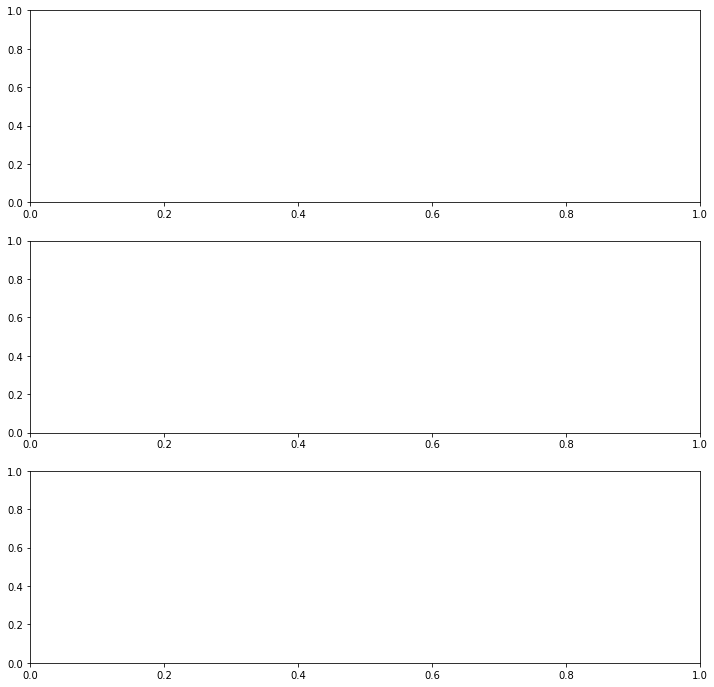

In [ ]:
loss_list = []
time_list = []
train_list = []
test_list = []
fig, axs = plt.subplots(3)
fig.set_figheight(12)
fig.set_figwidth(12)

for epoch in range(epochs):  # loop over the dataset multiple times
    epoch_start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = basic_cnn_model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss = running_loss + loss.item()
        #for accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        correct+= (predicted == labels).sum().item()
        total+=labels.size(0)
        print(f'epoch-{epoch} i - {i} , loss = {running_loss}')
    epoch_end_time = time.time()
    avg_running_loss = round(running_loss/i+1,3)
    time_taken = round(epoch_end_time - epoch_start_time,3)
    #plot purpose 
    loss_list.append(avg_running_loss)
    time_list.append(time_taken)
    train_list.append(round(correct/total,3))
    test_list.append(get_accuracy(testloader,basic_cnn_model))
    
    # print statistics
    print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], Time taken:[{time_taken} seconds], Loss: {avg_running_loss:.4f}')
    
x_values = np.arange(1,epochs+1)
axs[0].plot(x_values,loss_list,marker='o')
axs[0].set_xlabel("Number of Epochs")
axs[0].set_ylabel("Loss Values")
axs[1].bar(x_values,time_list)
axs[1].set_xlabel("Number of Epochs")
axs[1].set_ylabel("Time Taken (seconds)")
axs[2].plot(x_values,train_list , label = 'Train Accuracy')
axs[2].plot(x_values,test_list, label = 'Test Accuracy')
axs[2].set_xlabel("Number of Epochs")
axs[2].set_ylabel("Accuracy")
axs[2].legend()
plt.show()      
print('Finished Training')